All needed libraries and steps

In [123]:
#!pip3 install plotly==4.14.3
#!pip3 install -U datapane
#!sudo pip3 install matplotlib
#!pip3 install -U scikit-learn scipy matplotlib
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 --allow-root

import plotly.express as px
from pandas import DataFrame
from datetime import datetime, date, time, timedelta
import pandas as pd
import numpy as np
import datapane as dp
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import islice
import json

Data Import

In [124]:
#Import LTE network data from JSON file
data = []
with open('LTE.json') as f:
    for line in f:
        data.append(json.loads(line))

        #Convert JSON data from Python dict to DF
LTE_DATA = pd.json_normalize(data)
LTE_DATA.head()

,interface,timestamp,net_param.net_type,net_param.rsrq,net_param.rsrp,net_param.rssi,net_param.sinr,net_param.band,net_param.pci,uav_param.mode,...,gps_param.altitude,gps_param.groundspeed,gps_param.velocity.vx,gps_param.velocity.vy,gps_param.velocity.vz,gps_param.head,gps_param.hdop,gps_param.vdop,gps_param.satellites,gps_param.fix_type
0,eth1,2021-05-22 13:50:12.752036,LTE,-13.0,-93,<=-113,2,3,150,POSHOLD,...,16.52,0.11406989395618439,-0.08,0.07,0.09,180,71,105,15,4
1,eth1,2021-05-22 13:50:12.752036,LTE,-13.0,-93,<=-113,2,3,150,POSHOLD,...,16.52,0.11406989395618439,-0.08,0.07,0.09,180,71,105,15,4
2,eth1,2021-05-22 13:50:13.786250,LTE,-13.0,-93,<=-113,2,3,150,POSHOLD,...,16.5,0.09985339641571045,-0.06,0.07,0.09,180,71,105,15,4
3,eth1,2021-05-22 13:50:13.786250,LTE,-13.0,-93,<=-113,2,3,150,POSHOLD,...,16.5,0.09985339641571045,-0.06,0.07,0.09,180,71,105,15,4
4,eth1,2021-05-22 13:50:14.846186,LTE,-13.0,-93,<=-113,2,3,150,POSHOLD,...,16.53,0.09170739352703094,-0.04,0.07,0.08,180,71,105,15,4


Preliminary Data Clean

In [125]:
#Drop duplicate data where rows have same timestamp
LTE_DATA = LTE_DATA.drop_duplicates(subset=['timestamp'])

#Set LTE condition
LTE_net = LTE_DATA['net_param.net_type']=='LTE'
LTE_DATA = LTE_DATA[LTE_net]

#Replace all that values at the boudaries with integer values, so that they can be converted into float
LTE_DATA = LTE_DATA.replace(['>=-51','<=-113','<-20','<-19.5','<-140'],['-50','-120','-21','-20','-144'])

#Converto DF into float (only numbers)
LTE_DATA = LTE_DATA.apply(pd.to_numeric, errors='ignore')

#Set GPS_Fix condition
LTE_Null = LTE_DATA['gps_param.satellites']>=5
LTE_DATA = LTE_DATA[LTE_Null]

#Convert timestamp into datetime
LTE_DATA["timestamp"] = pd.to_datetime(LTE_DATA["timestamp"])

#Sort by time (needed for time clustering)
LTE_DATA = LTE_DATA.sort_values(by="timestamp")

#Print Dtypes for debug
print(LTE_DATA.dtypes)

interface                           object
timestamp                   datetime64[ns]
net_param.net_type                  object
net_param.rsrq                     float64
net_param.rsrp                       int64
net_param.rssi                       int64
net_param.sinr                       int64
net_param.band                       int64
net_param.pci                        int64
uav_param.mode                      object
uav_param.status                    object
uav_param.battery                  float64
uav_param.attitude.pitch           float64
uav_param.attitude.yaw             float64
uav_param.attitude.roll            float64
gps_param.latitude                 float64
gps_param.longitude                float64
gps_param.altitude                 float64
gps_param.groundspeed              float64
gps_param.velocity.vx              float64
gps_param.velocity.vy              float64
gps_param.velocity.vz              float64
gps_param.head                       int64
gps_param.h

Time clustering to separate different flight mission

In [138]:
#Convert timestamp of dataframe to python datetime
LTE_DATA.timestamp = LTE_DATA.timestamp.dt.to_pydatetime()
#LTE_DATA['timestamp'][100:450]

#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=2)
final = list()
tmp = list()

#First row
tmp.append(LTE_DATA.iloc[0,:])

#First datetime
previous = LTE_DATA.iloc[0,1]

#Scan dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LTE_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        #if len(tmp) > 2:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 100 rows
lte_flights = []
for i in range(len(final)):
    #print(len(final[i]))
    if len(final[i])>100:
        lte_flights.append(final[i])

#Print N° of flights
print("Found ", len(lte_flights), " flights")

#Print flight lenght
for i in range(len(lte_flights)):
    print("Flight N°", i+1, "has ", len(lte_flights[i]), " rows of data")

Found  10  flights
Flight N° 1 has  517  rows of data
Flight N° 2 has  867  rows of data
Flight N° 3 has  920  rows of data
Flight N° 4 has  669  rows of data
Flight N° 5 has  635  rows of data
Flight N° 6 has  680  rows of data
Flight N° 7 has  489  rows of data
Flight N° 8 has  392  rows of data
Flight N° 9 has  376  rows of data
Flight N° 10 has  612  rows of data


#Print preliminary data plots
for f in range(len(flights)):
    #define figures for plots
    fig = plt.figure(figsize = (12, 12)).add_subplot()
    DF = DataFrame (flights[f])

    #fig.plot(flights[f]['timestamp'], flights[f]['net_param.rssi'])
    fig.plot(DF['timestamp'], DF['net_param.sinr'])
    fig.plot(DF['timestamp'], DF['gps_param.altitude'])
    #fig.plot(LTE_DATA['timestamp'], LTE_DATA['net_param.rsrp'])
    #fig.plot(LTE_DATA['timestamp'], LTE_DATA['net_param.rsrq'])
    fig.plot(DF['timestamp'], DF['gps_param.groundspeed'])

    #add X, and Y labels
    fig.set_xlabel('Time')
    fig.set_ylabel('Data')
    fig.legend(['Sinr','Altitude','Ground Speed'])


In [122]:
flights[0]

[timestamp     2021-05-22 11:51:27.908408+00:00
 rssi                                      -107
 snr                                        6.0
 latitude                             44.990883
 longitude                            10.452408
 altitude                             22.890625
 hdop                                        66
 satellites                                  16
 speed                                 0.106384
 head                                     176.0
 gateways                                   NaN
 Name: 0, dtype: object,
 timestamp     2021-05-22 11:51:35.448530+00:00
 rssi                                      -109
 snr                                        4.0
 latitude                             44.990757
 longitude                            10.452408
 altitude                             24.578125
 hdop                                        66
 satellites                                  16
 speed                                   3.9375
 head          

Flight N° 1 has  517  rows of data
Flight N° 2 has  867  rows of data
Flight N° 3 has  920  rows of data
Flight N° 4 has  669  rows of data
Flight N° 5 has  635  rows of data
Flight N° 6 has  680  rows of data
Flight N° 7 has  612  rows of data


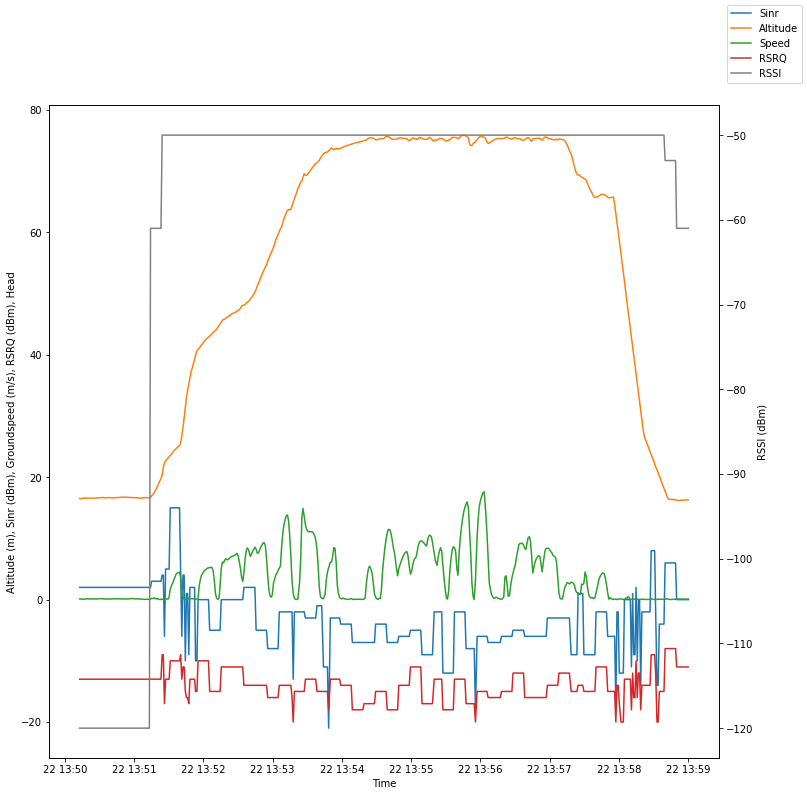

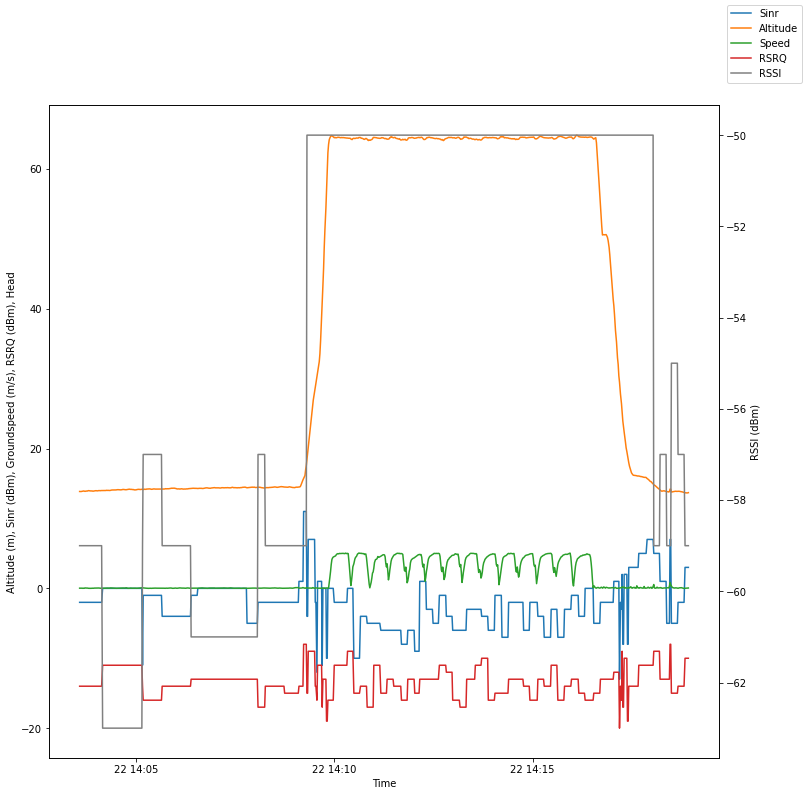

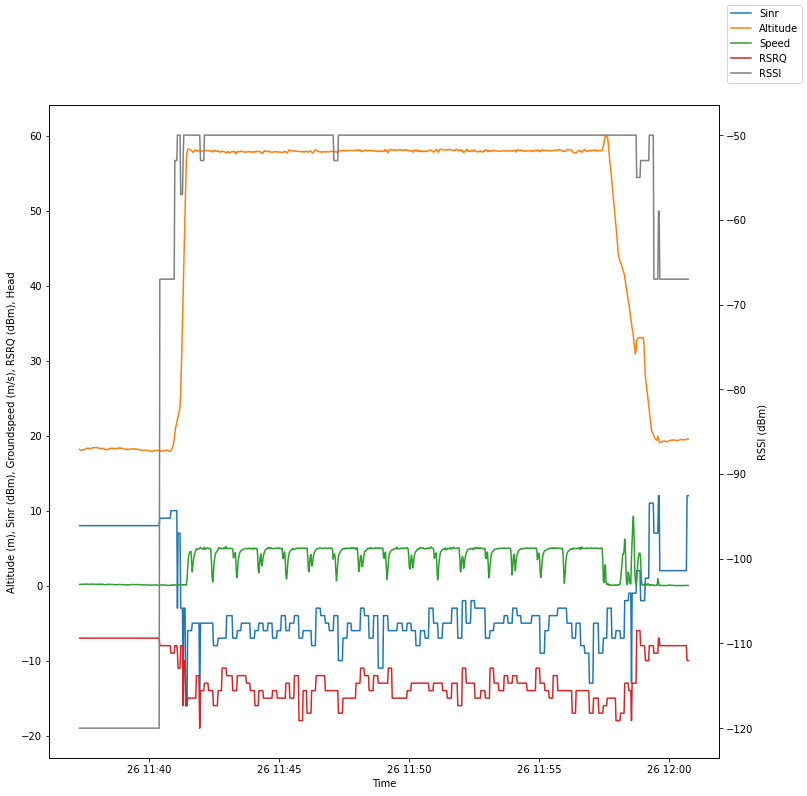

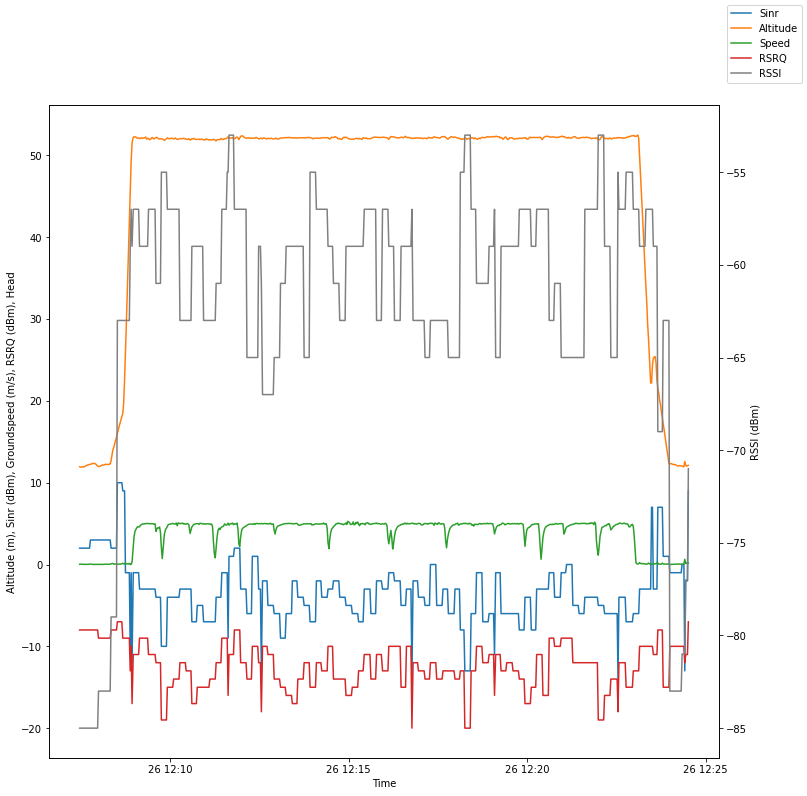

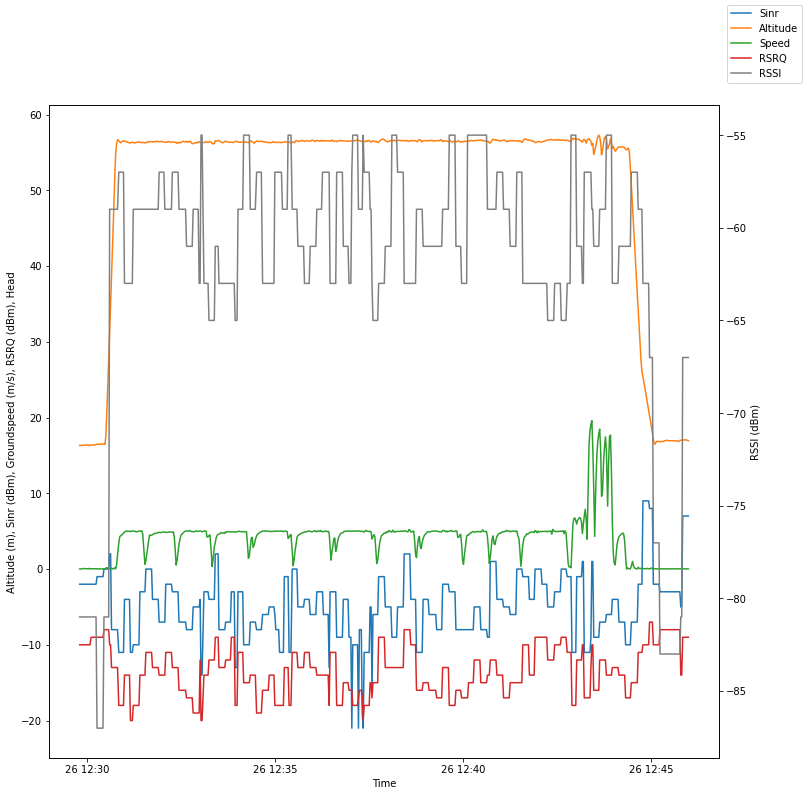

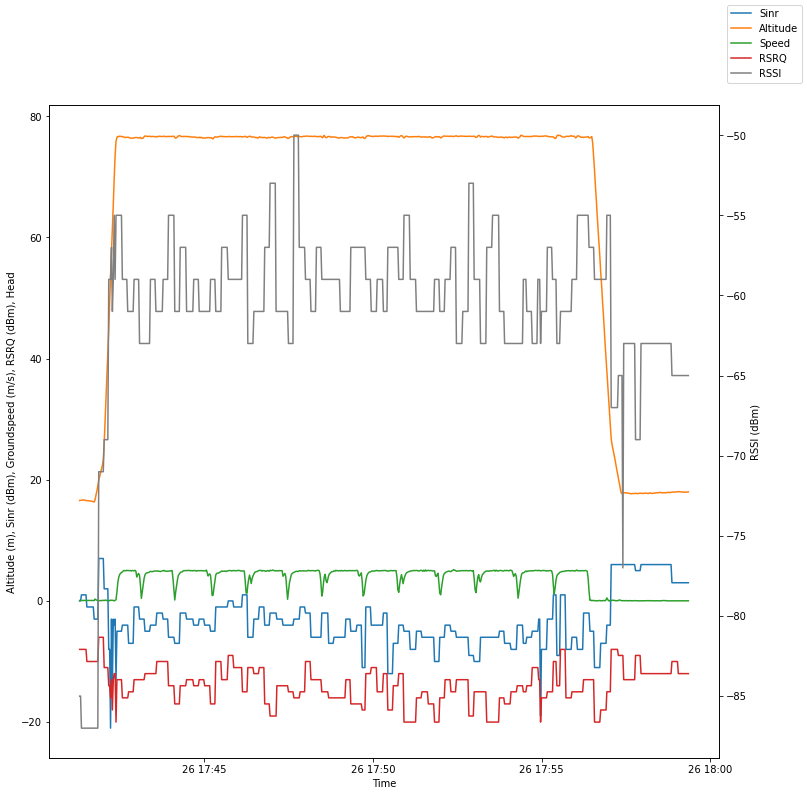

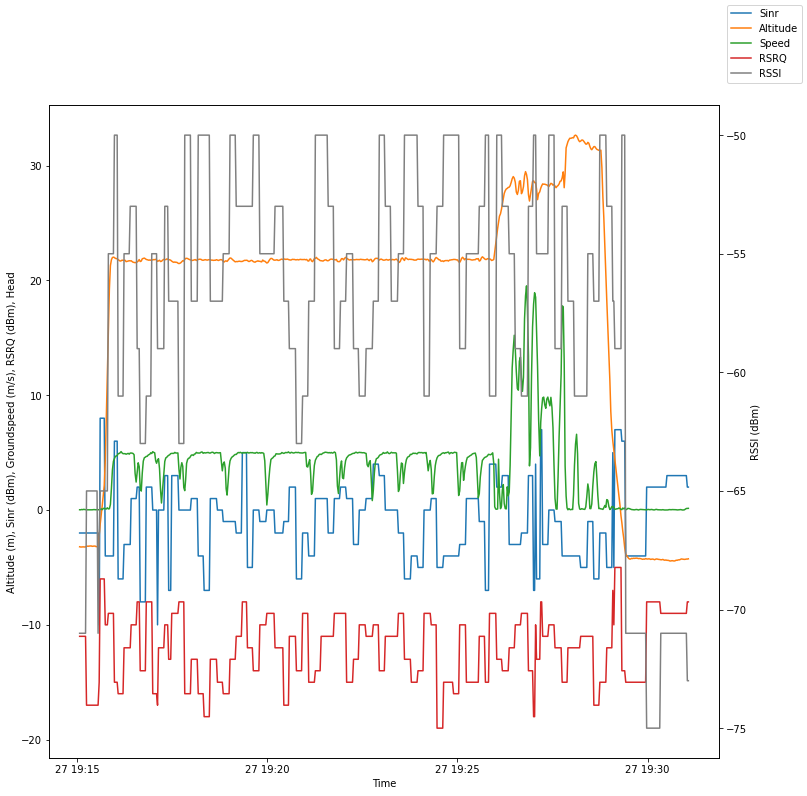

In [139]:
#Remove incomplete flights where there are missing data by check initial and final altitude with a 5 meter error margin due to air pressure change
lte_complete_flights = []
for i in range(len(lte_flights)):
    data = DataFrame (lte_flights[i])
    rth = abs(data.iloc[0,17] - data.iloc[-1,17])
    if rth<5:
        lte_complete_flights.append(data)
    
#Print complete flight
for i in range(len(lte_complete_flights)):
    print("Flight N°", i+1, "has ", len(lte_complete_flights[i]), " rows of data")
    
#Print complete flight data plots
for f in range(len(lte_complete_flights)):
    #get DF
    DF = DataFrame (lte_complete_flights[f])
    
    #define figures for plots
    fig, ax1 = plt.subplots(figsize = (12, 12))

    #Set first axis data
    ax1.plot(DF['timestamp'], DF['net_param.sinr'])
    ax1.plot(DF['timestamp'], DF['gps_param.altitude'])
    ax1.plot(DF['timestamp'], DF['gps_param.groundspeed'])
    ax1.plot(DF['timestamp'], DF['net_param.rsrq'])
    #ax1.plot(DF['timestamp'], DF['gps_param.head']/10)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Altitude (m), Sinr (dBm), Groundspeed (m/s), RSRQ (dBm), Head')
    #Set second axis data
    ax2 = ax1.twinx()
    ax2.plot(DF['timestamp'], DF['net_param.rssi'], color='gray')
    #ax2.plot(DF['timestamp'], DF['net_param.rsrp'], color='purple')
    ax2.set_ylabel('RSSI (dBm)')
    #Add legend
    fig.legend(['Sinr','Altitude','Speed','RSRQ','RSSI'])

    #Create scatter maps
    plot = px.scatter_mapbox(DF, lat='gps_param.latitude', lon='gps_param.longitude', color='net_param.sinr', size='gps_param.longitude', zoom=16,
                        mapbox_style="open-street-map")
    plot.show()


In [131]:
LTE_RSSI_HM = px.density_mapbox(LTE_DATA, lat='gps_param.latitude', lon='gps_param.longitude', z='net_param.rssi', zoom=12,
                        mapbox_style="open-street-map")

LTE_RSSI_HM.show()

#dp.Report(dp.Plot(LTE_RSSI_HM)).publish(name='LTE_RSSI_HeatMap_Ponteterra', open=True)

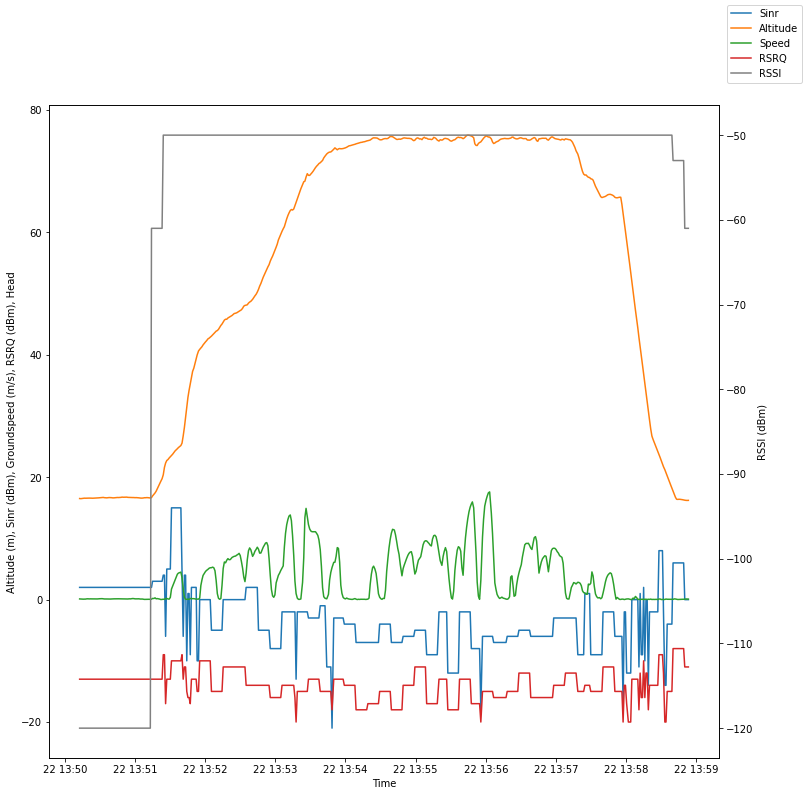

In [136]:
#define figures for plots
fig, ax1 = plt.subplots(figsize = (12, 12))

#Set first axis data
ax1.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.sinr'].head(510))
ax1.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['gps_param.altitude'].head(510))
ax1.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['gps_param.groundspeed'].head(510))
ax1.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.rsrq'].head(510))
#ax1.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['gps_param.head'].head(510)/10)
ax1.set_xlabel('Time')
ax1.set_ylabel('Altitude (m), Sinr (dBm), Groundspeed (m/s), RSRQ (dBm), Head')
#Set second axis data
ax2 = ax1.twinx()
ax2.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.rssi'].head(510), color='gray')
#ax2.plot(LTE_DATA['timestamp'].head(510), LTE_DATA['net_param.rsrp'].head(510), color='purple')
ax2.set_ylabel('RSSI (dBm)')
#Add legend
fig.legend(['Sinr','Altitude','Speed','RSRQ','RSSI'])
#Show graph
plt.show()

[[45.00562988 10.46169944]
 [44.99040582 10.45255975]
 [45.0074684  10.46378346]
 [45.00628741 10.45730022]]


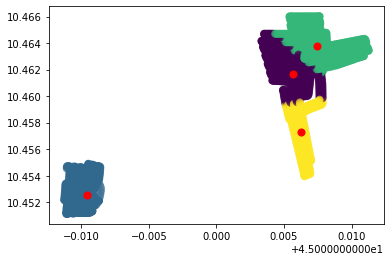

In [116]:
#GEO Clustering attempt
df = DataFrame(LTE_DATA,columns=['gps_param.latitude','gps_param.longitude'])

kmeans = KMeans(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['gps_param.latitude'], df['gps_param.longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [132]:
#Lorawan Data Import and Analysis
data = []
with open('LORAWAN.json') as f:
    for line in f:
        data.append(json.loads(line))

LORA_DATA = pd.json_normalize(data)

#Drop duplicate data where rows have same timestamp
LORA_DATA = LORA_DATA.drop_duplicates(subset=['timestamp'])

#Converto DF into float (only numbers)
LORA_DATA = LORA_DATA.apply(pd.to_numeric, errors='ignore')

#Set LORA condition
LORA_Null = LORA_DATA['satellites']>=5
#LORA_net = LORA_DATA['snr'].notna()
#LORA_net = LORA_DATA['gateways'].notna()

#Select only LORA data
LORA_DATA = LORA_DATA[LORA_Null]

#Convert timestamp into datetime
LORA_DATA["timestamp"] = pd.to_datetime(LORA_DATA["timestamp"])

#Sort by time (needed for time clustering)
LORA_DATA = LORA_DATA.sort_values(by="timestamp")

#Print Dtypes for debug
print(LORA_DATA.dtypes)

LORA_DATA.head()

timestamp     datetime64[ns, UTC]
rssi                        int64
snr                       float64
latitude                  float64
longitude                 float64
altitude                  float64
hdop                        int64
satellites                  int64
speed                     float64
head                      float64
gateways                   object
dtype: object


,timestamp,rssi,snr,latitude,longitude,altitude,hdop,satellites,speed,head,gateways
0,2021-05-22 11:51:27.908408+00:00,-107,6.0,44.990883,10.452408,22.890625,66,16,0.106384,176.0,NaN
2,2021-05-22 11:51:35.448530681+00:00,-109,4.0,44.990757,10.452408,24.578125,66,16,3.937500,177.0,NaN
4,2021-05-22 11:51:42.971167228+00:00,-105,7.0,44.990551,10.452424,29.765625,66,16,0.066162,175.0,NaN
6,2021-05-22 11:51:50.512653127+00:00,-101,9.0,44.990551,10.452423,38.250000,66,16,0.137207,176.0,NaN
8,2021-05-22 11:51:58.016596124+00:00,-109,-0.8,44.990528,10.452511,41.625000,66,16,3.958984,105.0,NaN


Found 8 complete flights:
Flight N° 1 has  59  rows of data
Flight N° 2 has  81  rows of data
Flight N° 3 has  184  rows of data
Flight N° 4 has  132  rows of data
Flight N° 5 has  130  rows of data
Flight N° 6 has  135  rows of data
Flight N° 7 has  166  rows of data
Flight N° 8 has  121  rows of data


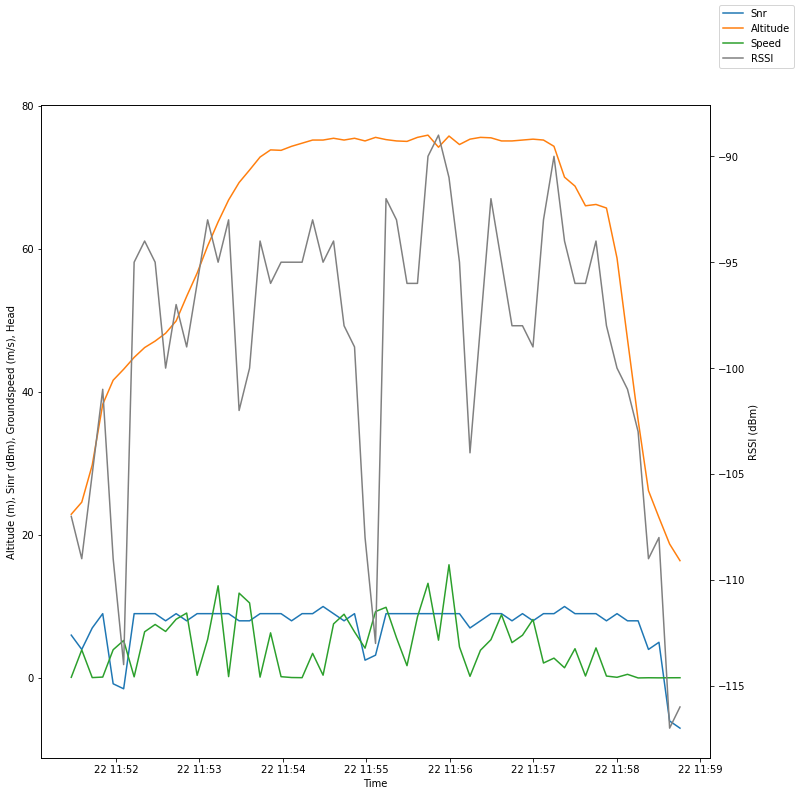

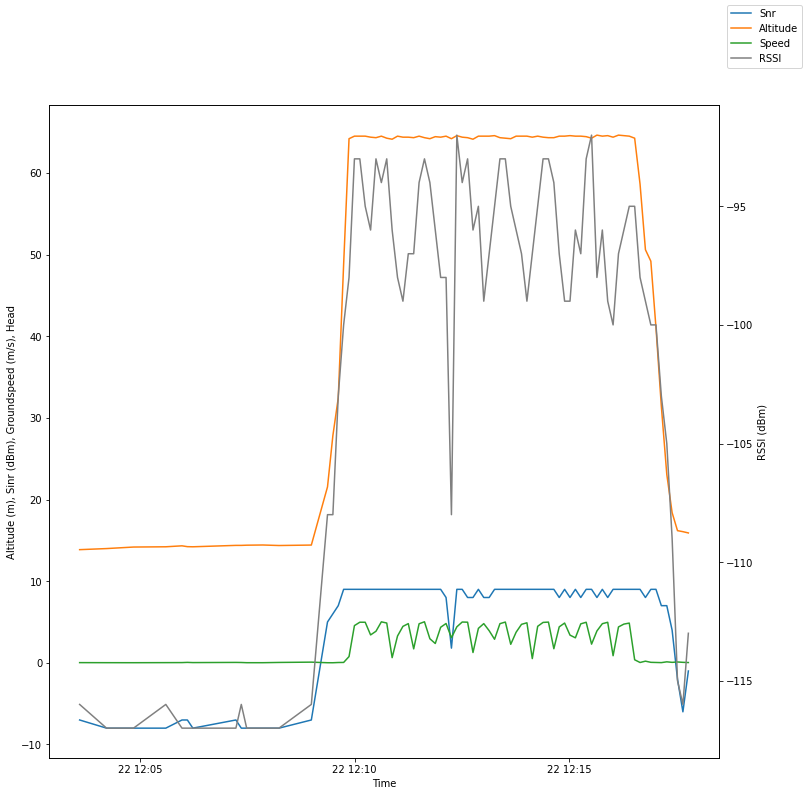

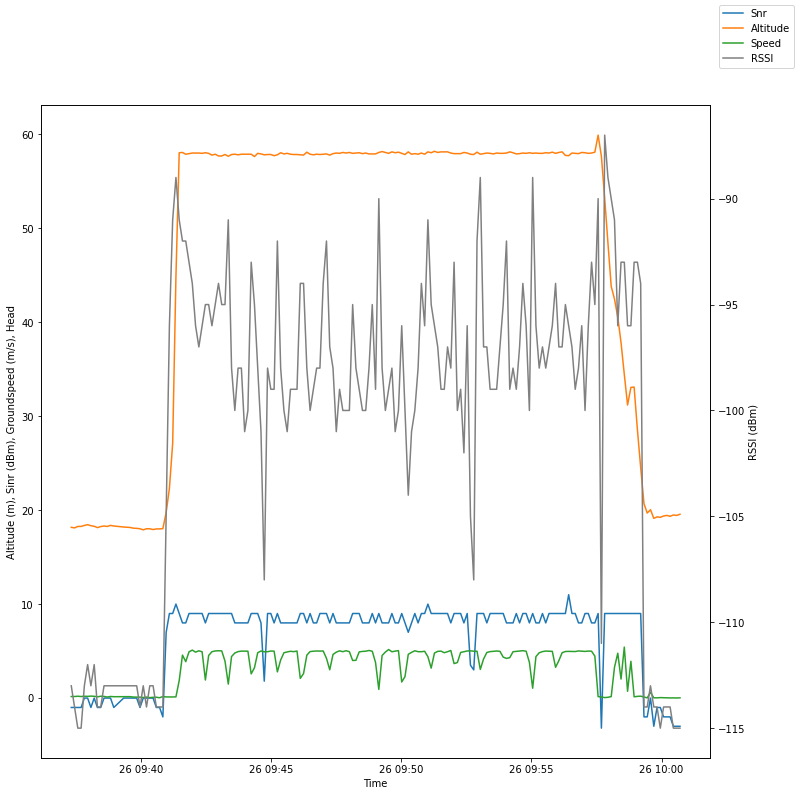

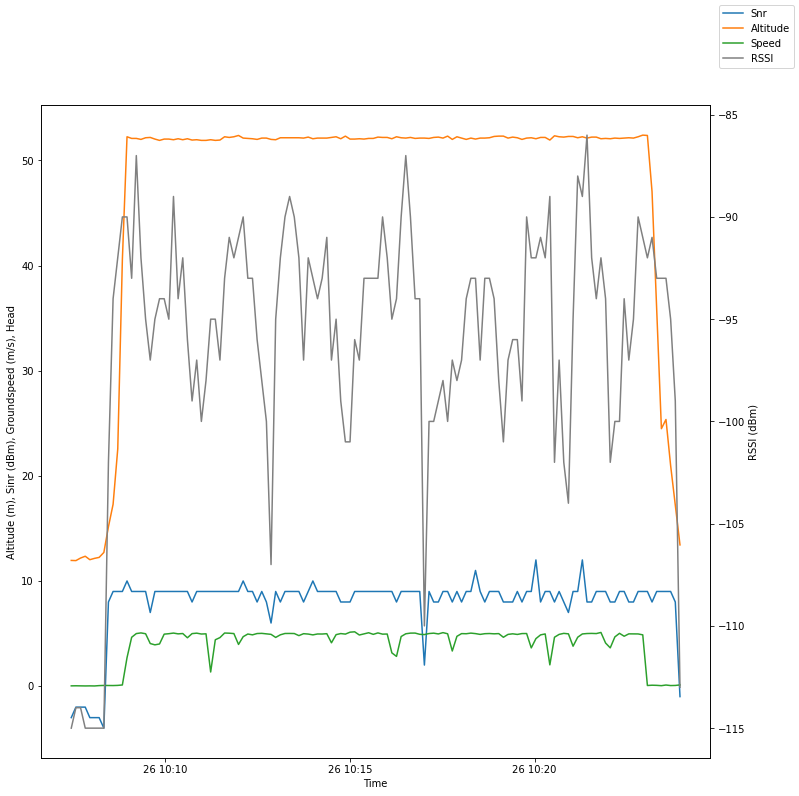

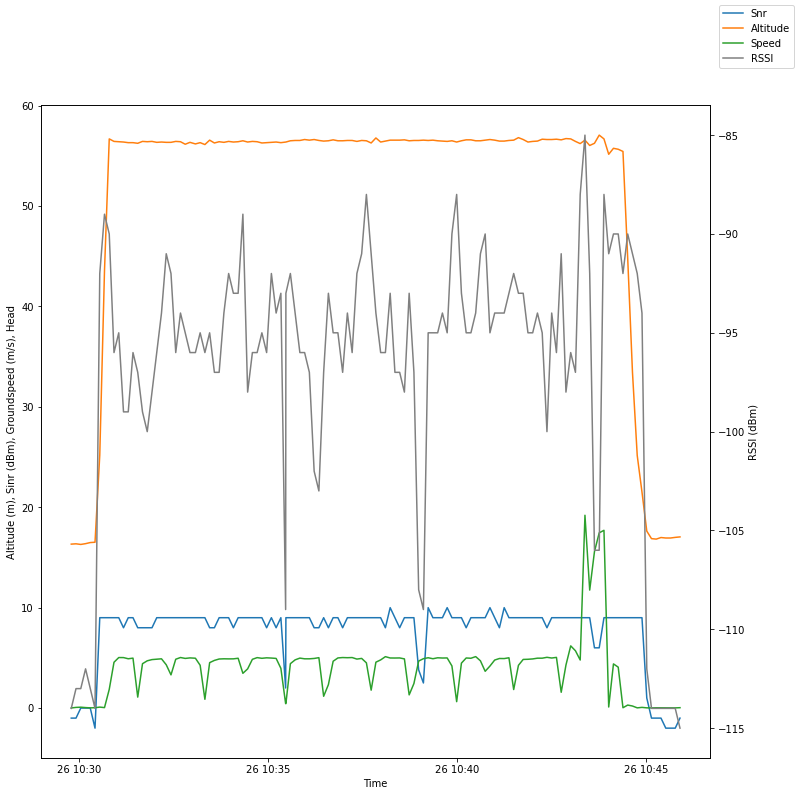

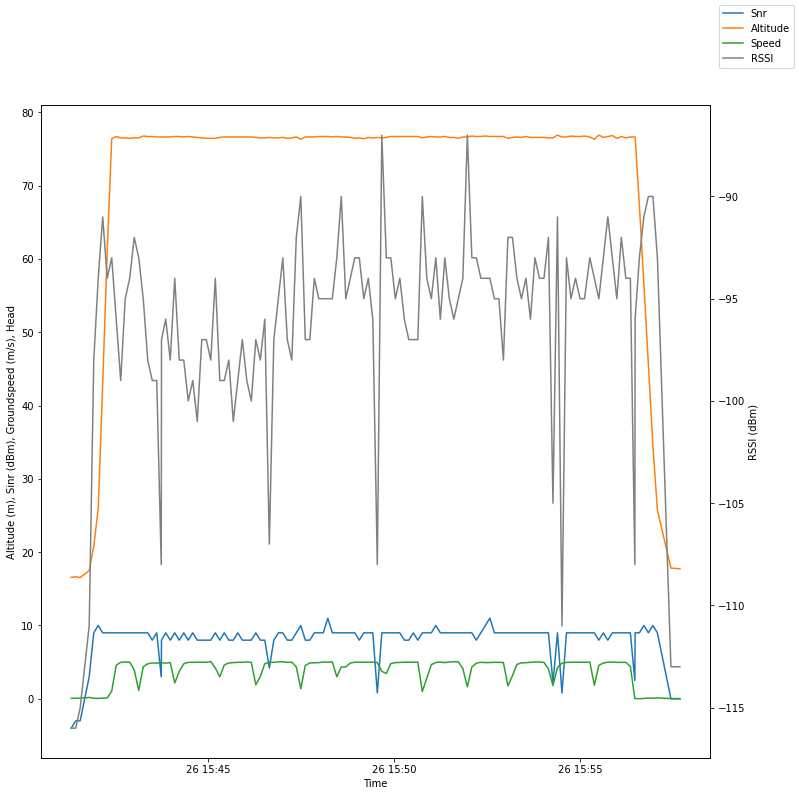

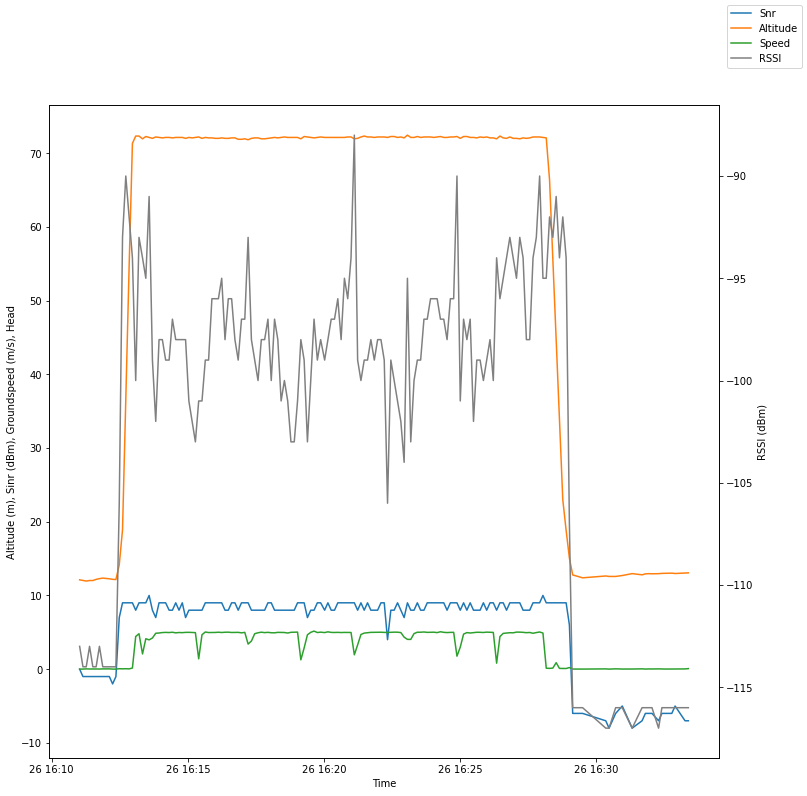

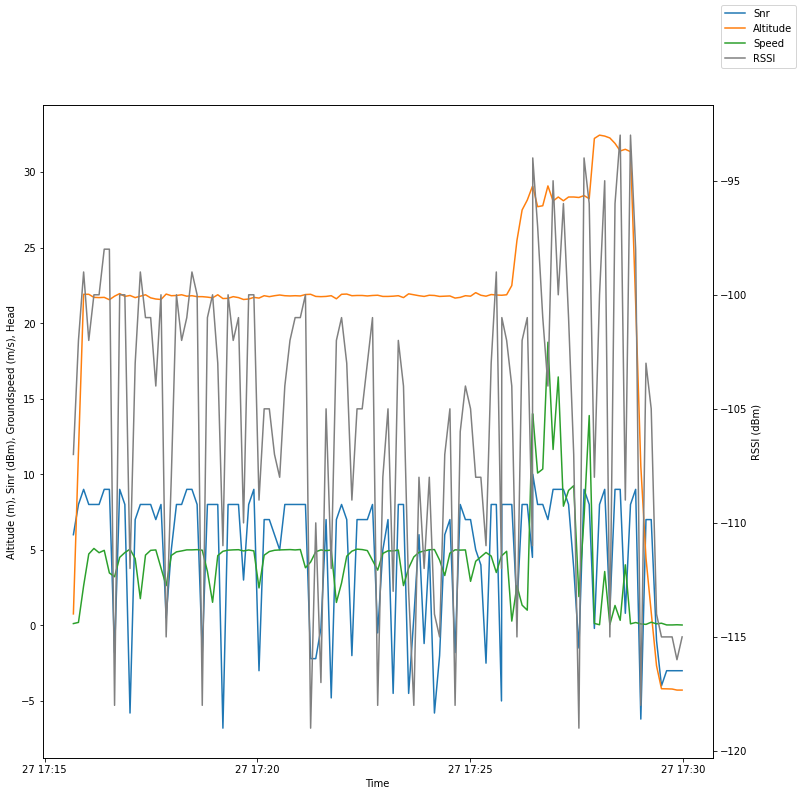

In [140]:
#Convert timestamp of dataframe to python datetime
LORA_DATA.timestamp = LORA_DATA.timestamp.dt.to_pydatetime()

#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=4)
final = list()
tmp = list()

#First row
tmp.append(LORA_DATA.iloc[0,:])

#First datetime
previous = LORA_DATA.iloc[0,0]

#Scan dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LORA_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 50 rows
lora_flights = []
for i in range(len(final)):
    #print(len(final[i]))
    if len(final[i])>50:
        lora_flights.append(final[i])
   
#Remove incomplete flights where there are missing data by check initial and final altitude with a 10 meter error margin due to air pressure change
lora_complete_flights = []
for i in range(len(lora_flights)):
    data = DataFrame (lora_flights[i])
    rth = abs(data.iloc[0,5] - data.iloc[-1,5])
    if rth<10:
        lora_complete_flights.append(data)
    
#Print complete flight
print("Found", len(lora_complete_flights), "complete flights:")
for i in range(len(lora_complete_flights)):
    print("Flight N°", i+1, "has ", len(lora_complete_flights[i]), " rows of data")
    
#Print complete flight data plots
for f in range(len(lora_complete_flights)):
    DF = DataFrame (lora_complete_flights[f])

    #define figures for plots
    fig, ax1 = plt.subplots(figsize = (12, 12))

    #Set first axis data
    ax1.plot(DF['timestamp'], DF['snr'])
    ax1.plot(DF['timestamp'], DF['altitude'])
    ax1.plot(DF['timestamp'], DF['speed'])
    #ax1.plot(DF['timestamp'], DF['head']/10)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Altitude (m), Sinr (dBm), Groundspeed (m/s), Head')
    #Set second axis data
    ax2 = ax1.twinx()
    ax2.plot(DF['timestamp'], DF['rssi'], color='gray')
    ax2.set_ylabel('RSSI (dBm)')
    #Add legend
    fig.legend(['Snr','Altitude','Speed','RSSI'])
    
    
    plot = px.scatter_mapbox(DF, lat='latitude', lon='longitude', color='snr', size='longitude', zoom=16,
                        mapbox_style="open-street-map")
    plot.show()


In [119]:
#Since there was some missing fields (RSSI and SNR) in the lastest measurment, which where included into gateways, I extracted these value from that field and I rewrite the file with the missing values of RSSI and SNR
for rows in data:
    if 'gateways' in rows:
        #print(rows['gateways'])
        #print(type(rows['gateways']))
        RSSI = []
        SNR = []
        for value in range(len(rows["gateways"])):
            RSSI.append(rows["gateways"][value]["rssi"])
            SNR.append(rows["gateways"][value]["snr"])
        output = {"timestamp":rows["timestamp"],"rssi":max(RSSI), "snr":max(SNR), "latitude":rows['latitude'],"longitude":rows['longitude'],"altitude":rows['altitude'],"hdop":rows['hdop'],"satellites":rows['satellites'],"speed":rows['speed'],"head":rows['head'],"gateways":rows["gateways"]}
        print(output)
    else:
        output = rows
        
    #with open('LORAWAN_CLEAN.json', 'a') as outfile:
        #json.dump(output, outfile, ensure_ascii=False)
        #outfile.write('\n')
        

TypeError: string indices must be integers